In [66]:
%pylab inline
import pandas as pd
import requests
from pprint import pprint

Populating the interactive namespace from numpy and matplotlib


/home/mhelf/.local/share/virtualenvs/helpernb-uRpGV3Tr/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['get']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Config

In [2]:
api = 'http://localhost:3000/api'

# Helpers

In [59]:
def get(endpoint):
    res = requests.get(f'{api}/{endpoint}')
    return res.json()

In [60]:
def post(endpoint, **kwargs):
    res = requests.post(f'{api}/{endpoint}', json=kwargs)
    res.raise_for_status()
    return res.json()

In [61]:
get('info')

{'version': '0.6.8'}

In [486]:
def pull_dataranges():
    data = post('scansets')
    dataranges = pd.DataFrame(data['datasets'])
    dataranges = (
        dataranges.join(
            dataranges['ranges']
            .apply(pd.Series)
            .reset_index()
            .melt(id_vars='index')
            .dropna()[['index', 'value']]
            .set_index('index')
        )
        .drop('ranges', axis=1)
        .rename(dict(value='range'), axis=1)
        .dropna(subset=['range'])
    )
    dataranges['from'] = (
        pd.to_datetime(
            dataranges.range.apply(lambda x: x['from']),
            unit='s'
        )
    )
    dataranges['to'] = (
        pd.to_datetime(
            dataranges.range.apply(lambda x: x['to']),
            unit='s'
        )
    )
    dataranges = (
        dataranges
        .drop('range', axis=1)
    )

    return dataranges

In [488]:
def build_backtest_config(exchange, asset, currency, candlesize, strategy, strat_config, date_start=None, date_end=None):
    cfg_template = {
        "watch": {
        },
        "paperTrader": {
            "feeMaker": 0.25,
            "feeTaker": 0.25,
            "feeUsing": "maker",
            "slippage": 0.05,
            "simulationBalance": {
                "asset": 1,
                "currency": 100
            },
            "reportRoundtrips": True,
            "enabled": True
        },
        "tradingAdvisor": {
            "enabled": True,
            "historySize": 200
        },
        "backtest": {
            "daterange": {
            }
        },
        "backtestResultExporter": {
            "enabled": True,
            "writeToDisk": False,
            "data": {
                "stratUpdates": True,
                "roundtrips": True,
                "stratCandles": True,
                "stratCandleProps": [
                    "open", "high", "low", "close", 
                ],
                "trades": True
            }
        },
        "performanceAnalyzer": {
            "riskFreeReturn": 2,
            "enabled": True
        }
    }
    
    
    # auto-impute date_start/date_end with min/max of first matching range
    if date_start is None or date_end is None:
        dr = pull_dataranges()
        dr = dr[(dr.exchange == exchange) & (dr.asset == asset) & (dr.currency == currency)]
        if len(dr) == 0:
            raise ValueError(f'no data ranges match specified exchange/asset/currency combination ({asset}/{currency}@{exchange})')
        if date_start is None:
            date_start = dr.iloc[0,:]['from']
        if date_end is None:
            date_end = dr.iloc[0,:]['to']
    if date_start is not None:
        date_start = pd.to_datetime(date_start)
    if date_end is not None:
        date_end = pd.to_datetime(date_end)

    # fill config template
    cfg = cfg_template.copy()
    cfg[strategy] = strat_config
    cfg['tradingAdvisor']['method'] = strategy
    cfg['tradingAdvisor']['candleSize'] = candlesize
    cfg['watch'] = dict(
        exchange=exchange,
        currency=currency,
        asset=asset,
    )
    cfg['backtest']['daterange']['from'] = date_start.isoformat()
    cfg['backtest']['daterange']['to'] = date_end.isoformat()
    return cfg

In [489]:
def assembleJointDF(jdf, shortRatio):
    jdf['lastAction'] = jdf.action.ffill()
    jdf['lastAmount'] = jdf.amount.ffill()
    jdf['lastBalance'] = jdf.balance.ffill()
    jdf['profit'] = (jdf.close / startPrice).diff()
    jdf['profit'] = jdf.apply(lambda row: row.profit*(1-shortRatio) if row.lastAction=='buy' else (-row.profit * shortRatio if row.lastAction=='sell' else 0), axis=1)
    jdf['cumProfit'] = (1+jdf.profit.cumsum())#*(startBalance)
    jdf['currentBalance'] = jdf.apply(lambda row: row['lastBalance'] if row['lastAction'] == 'sell' else row['lastAmount'] * row['open'], axis=1).fillna(report['startBalance'])
    jdf['marketP'] = jdf.close / startPrice
    jdf['stratP'] = jdf.currentBalance / startBalance
    jdf['marketMax'] = jdf.marketP.cummax()
    jdf['stratMax'] = jdf.stratP.cummax()
    jdf['profitMax'] = jdf.cumProfit.cummax()
    jdf['marketDrawdown'] = -(1 - jdf.marketP / jdf.marketMax)
    jdf['stratDrawdown'] = -(1 - jdf.stratP / jdf.stratMax)
    jdf['profitDrawdown'] = -(1 - jdf.cumProfit / jdf.profitMax)
    jdf['date'] = jdf.index
    return jdf

def backtest(config, shortRatio=0.5):

    res = post('backtest', **bt_config)

    roundtrips = pd.DataFrame(res['roundtrips'])
    roundtrips.entryAt = pd.to_datetime(roundtrips.entryAt, unit='s')
    roundtrips.exitAt = pd.to_datetime(roundtrips.exitAt, unit='s')

    candles = pd.DataFrame(res['stratCandles']).set_index('start')
    indicators = pd.DataFrame(res['stratUpdates']).set_index('date')
    trades = pd.DataFrame(res['trades']).set_index('date')

    candles.index = pd.to_datetime(candles.index, unit='s')
    indicators.index = pd.to_datetime(indicators.index, unit='s')
    trades.index = pd.to_datetime(trades.index, unit='s')

    indicators = pd.concat([indicators, indicators.indicators.apply(pd.Series)], axis=1).drop('indicators', axis=1)
    indicators.columns = [f"ind_{c}" for c in indicators.columns]

    report = res['performanceReport']
    print(report)

    jdf = (
        candles
        .join(indicators)
        .join(trades)
        .join(roundtrips.set_index('entryAt')[['entryBalance']])
        .join(roundtrips.set_index('exitAt')[['exitBalance']])
    )
    jdf.head()

    startBalance = report['startBalance']
    startPrice = candles['close'].iloc[0]


    jjdf = assembleJointDF(jdf, shortRatio=0.5)
    jjdf[['close', 'action', 'lastAction', 'profit', 'marketP', 'stratP', 'cumProfit']].head()

    # Profits
    def first(df):
        return df.iloc[0,:]
    def last(df):
        return df.iloc[-1,:]

    groups = jdf[['currentBalance', 'close', 'cumProfit']].groupby(pd.Grouper(freq='M'))
    firsts = groups.apply(first)
    lasts = groups.apply(last)
    firsts.columns = [f"f{c}" for c in firsts.columns]
    lasts.columns = [f"l{c}" for c in lasts.columns]
    profits = pd.concat([firsts, lasts], axis=1)
    profits.index = [d.date() for d in profits.index]
    profits['marketProfit'] = (profits.lclose - profits.fclose) / profits.fclose
    profits['stratProfit'] = (profits.lcurrentBalance - profits.fcurrentBalance) / profits.fcurrentBalance
    profits['cumcumProfit'] = (profits.lcumProfit - profits.fcumProfit) / profits.fcumProfit
    return report, jdf, profits

In [494]:
def plotStats(jdf, profit_per_month):
#     plt.figure()
    fig, axes = plt.subplots(4,1, figsize=(20,25))
    axidx = 0
    alpha = .4
    
    # Market
    ax = axes[0]
    jdf[['close']].plot(ax=ax)
#     (jdf[[c for c in jdf.columns if c.startswith('ind_')]]).plot(ax=ax)  # indicators
    jdf[jdf.action == 'buy'].plot(x='date', y='close',  ls='', marker=matplotlib.markers.CARETUP, ax=ax, ms=10, color='green', label='buy')
    jdf[jdf.action == 'sell'].plot(x='date', y='close', ls='', marker=matplotlib.markers.CARETDOWN, ax=ax, ms=10, color='red', label='sell')
    ax.set_yscale('log')
    ax.set_title('market')
    ax.grid()

    # Profits
    axidx += 1
    ax = axes[axidx]
    profit[[
        'marketProfit', 
        'stratProfit', 
#         'cumcumProfit'
    ]].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',)
    ax.axhline(0, c='black', lw=1.5)
    ax.grid()

    # Strategy
    axidx += 1
    ax = axes[axidx]
    jdf[[
        'marketP', 
        'stratP', 
#         'cumProfit'
    ]].plot(ax=ax)
    jdf[jdf.action == 'buy'].plot(x='date', y='stratP',  ls='', marker=matplotlib.markers.CARETUP, ax=ax, ms=10, color='green', label='buy', alpha=alpha)
    jdf[jdf.action == 'sell'].plot(x='date', y='stratP', ls='', marker=matplotlib.markers.CARETDOWN, ax=ax, ms=10, color='red', label='sell', alpha=alpha)
    ax.set_yscale('log')
    ax.set_title('profit')
    ax.grid()

    # Downside
    axidx += 1
    ax = axes[axidx]
    jdf[['marketDrawdown', 'stratDrawdown', 'profitDrawdown']].plot(ax=ax)
    ax.set_title('drawdown')
    ax.grid()
    plt.tight_layout()

{'startTime': '2019-01-01 01:59:00', 'endTime': '2019-02-01 00:01:00', 'timespan': 'a month', 'market': -6.928766373326752, 'balance': 3350.16532149, 'profit': -439.52467850999983, 'relativeProfit': -11.597905857998938, 'yearlyProfit': -5192.211783895414, 'relativeYearlyProfit': -137.00887892929015, 'startPrice': 3689.69, 'endPrice': 3434.04, 'trades': 6, 'startBalance': 3789.69, 'exposure': 0.28031085755356905, 'sharpe': -33.98385453416547, 'downside': -8.8882204088967, 'alpha': -432.59591213667306}


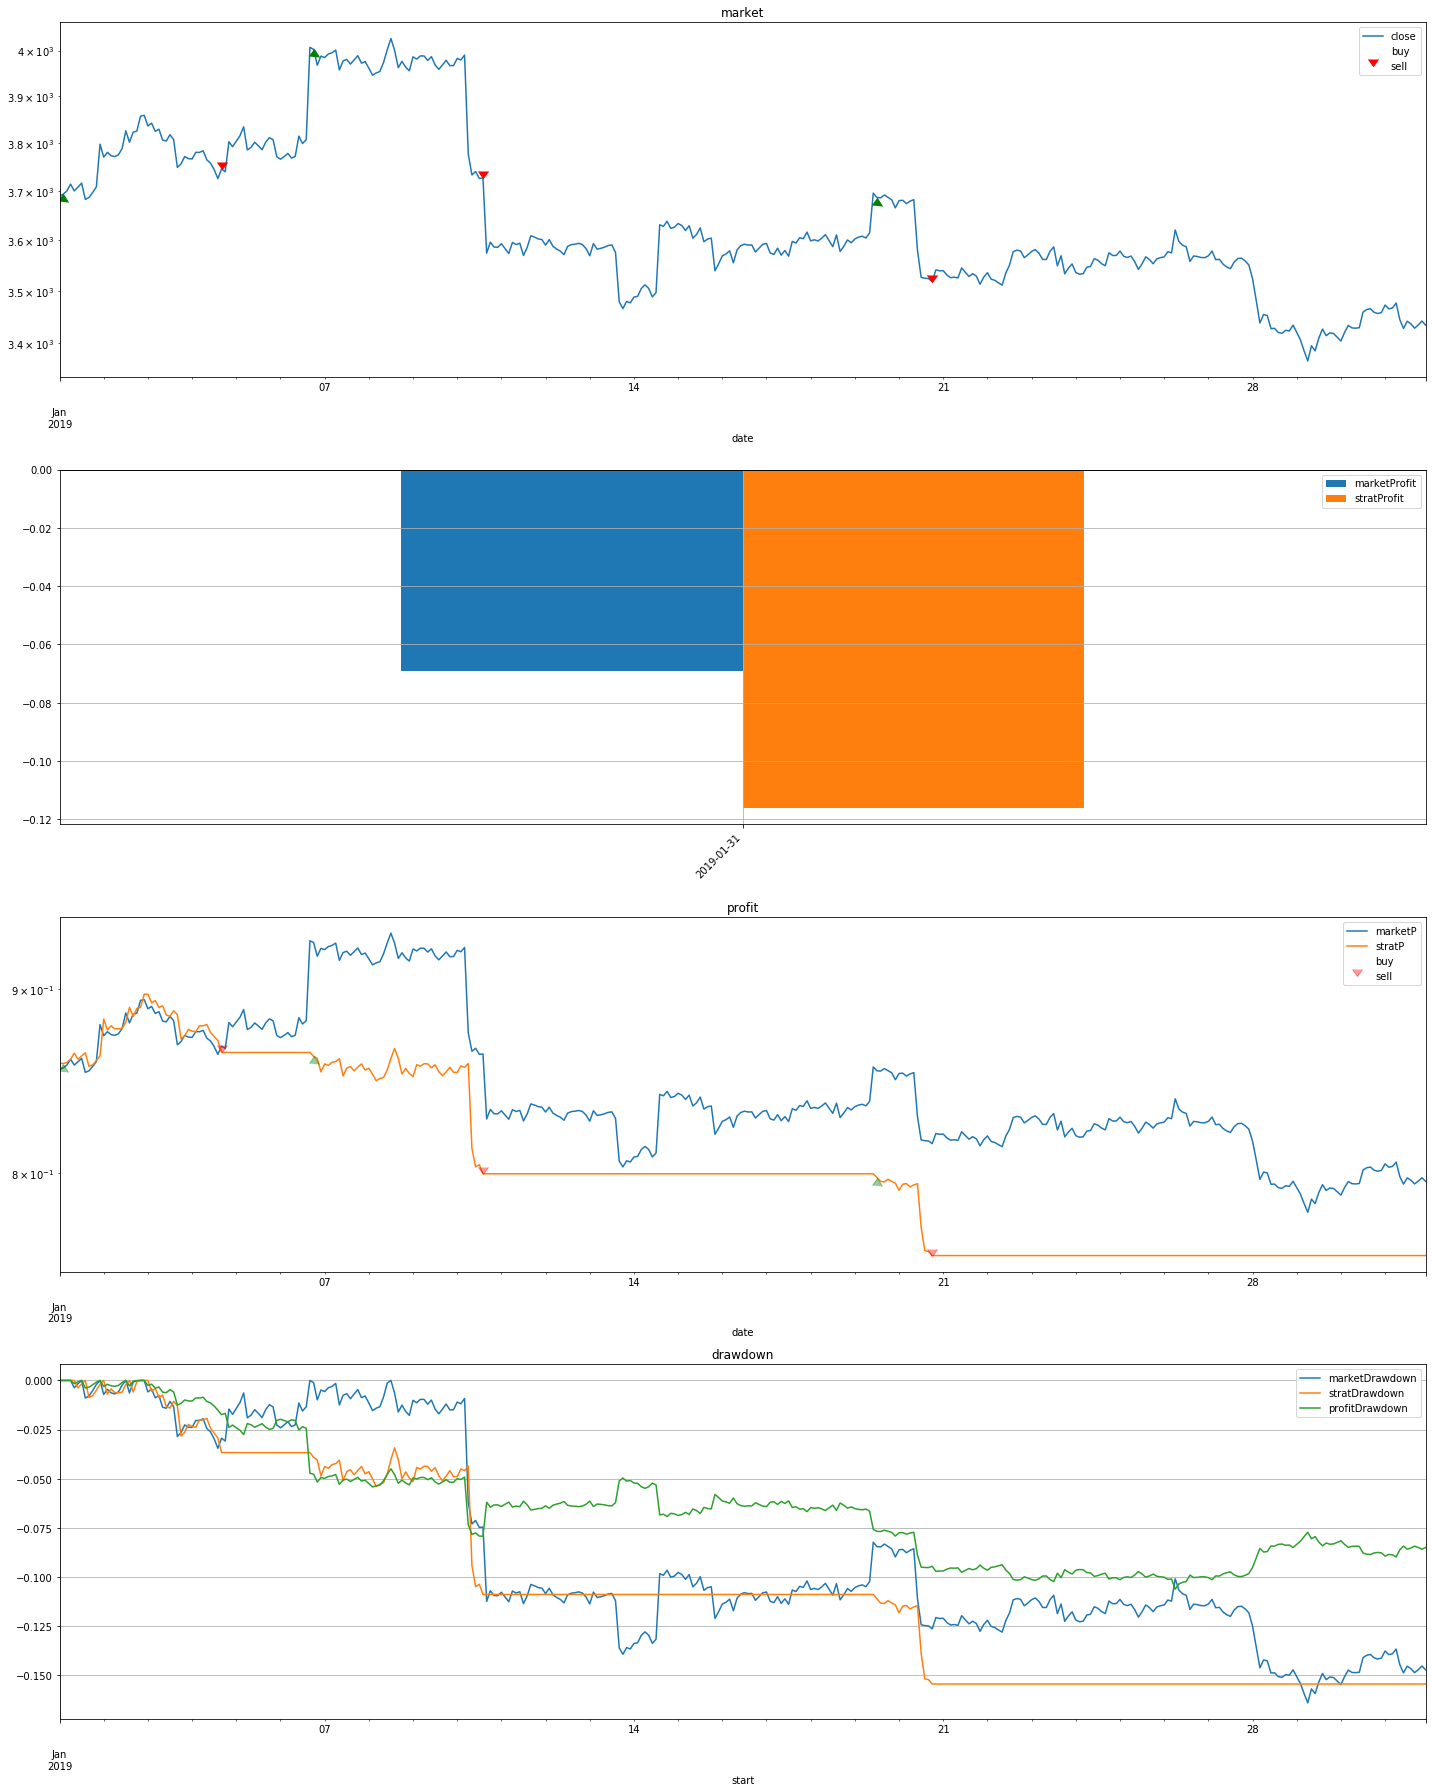

In [495]:
yant_cfg = {
    "emaPeriod": 42,
    "atrPeriod": 10,
    "candleSize": 120,
    "historySize": 200,
    "enterPeriods": 16,
    "exitDonchian": 31,
    "entryDonchian": 76,
    "exitAtrFactor": 0,
    "exitPersistency": 3
}
bt_config = build_backtest_config(
    exchange='binance', 
    asset='BTC', 
    currency='USDT', 
    candlesize=120, 
    strategy='YANT', 
    strat_config=yant_cfg, 
    date_start='2019-01-01', 
    date_end='2019-02-01'
)

report, jdf, profit = backtest(bt_config)
plotStats(jdf, profit);